<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/Portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install yfinance
!pip install lightning

In [ ]:
import pandas as pd
import yfinance as yf

assets = "AAPL MSFT AMZN TSLA GOOG BRK-B"
StockStartDate = '2018-01-01'
StockEndDate = '2018-12-31'
interval = '1d'

df = yf.download(assets, start=StockStartDate,\
                 end=StockEndDate, interval=interval)['Adj Close']

# daily return distribution
ret = df.pct_change().dropna()

# mean return vector & covariance matrix (annualized)
R = ret.mean()*252
Sigma = ret.cov()*252

[*********************100%%**********************]  6 of 6 completed


In [ ]:
!pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# define parameters in H
N = 6      # number of total assets
gamma = 1  # risk aversion coefficient
B = 3      # budget
P = 1.0    # penalty

ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(N) for j in range(i+1,N)]
ZZ_coeff = [0.5*(gamma*Sigma.values[i][j] + P) for i in range(N) for j in range(i+1,N)]
Z = [qml.PauliZ(i) for i in range(N)]
Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]
C = 0.25*gamma*(sum(sum(Sigma.values)) + np.trace(Sigma))- 0.5*sum(R) + 0.25*P*(N + (N-2*B)**2)

# Construct the problen Hamiltonian
obs = ZZ + Z
coeffs = ZZ_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

C:\Users\mbrat\AppData\Local\Temp\ipykernel_258476\1999095685.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R[i] - 0.5*P*(N-2*B) for i in range(N)]


In [ ]:
# Design the ansatz
p = 2     # circuit repetitions
def ansatz(params, qubits, depth=p):
    for q in range(qubits):
            qml.RY(params[q], wires=q)
    for d in range(1,depth+1):
        for q in range(qubits-1):
            qml.CNOT(wires=[q,q+1])
        for q in range(qubits):
            qml.RY(params[d*qubits+q], wires=q)

In [ ]:
dev = qml.device("lightning.qubit", wires=N)

# Set the cost function on dev
@qml.qnode(dev, diff_method="parameter-shift")
def cost(x):
    ansatz(x, qubits=N)
    return qml.expval(H)

# For analyze the optimized circuit
@qml.qnode(dev)
def probability_circuit(params):
    ansatz(params, qubits=N)
    return qml.probs(wires=range(N))

In [ ]:
def qng_session(params, stepsize=0.07, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.999999
  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params

In [ ]:
def momentum_qng_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize)
  old_cost = 9999.999999
  prev_step = params*0
  for i in range(steps):
      prev_params = params
      params = opt.step(cost, params) + momentum*prev_step
      prev_step = params - prev_params
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params



In [ ]:
def momentum_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.MomentumOptimizer(stepsize=stepsize, momentum=momentum)
  old_cost = 9999.999999
  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params

In [ ]:
def adam_session(params, stepsize=0.04, steps=300):
  opt = qml.AdamOptimizer(stepsize=stepsize)
  old_cost = 9999.999999
  for i in range(steps):
      params = opt.step(cost, params)
      obj_value = cost(params)
      #cost_qng.append(obj_value)
      if (i + 1) % 5 == 0:
          #print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
          if np.round(old_cost, 7) == np.round(obj_value, 7):
              break
          else:
              old_cost = obj_value
  return params

In [ ]:
from tqdm import tqdm

100%|██████████| 100/100 [1:11:26<00:00, 42.86s/it]

Cost after shot   100: adam: -1.5014588, qng: -1.5002298, mqng: -1.6859616, sgd: -1.5014636
[0.01, 0.33, 0.18, 0.19]


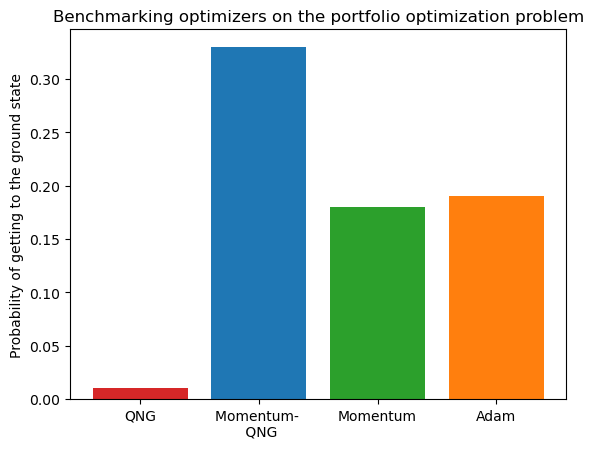

100%|██████████| 100/100 [2:18:24<00:00, 83.04s/it] 

Cost after shot   200: adam: -1.6859581, qng: -1.6858287, mqng: -1.6859603, sgd: -1.6859582
[0.015, 0.365, 0.17, 0.17]


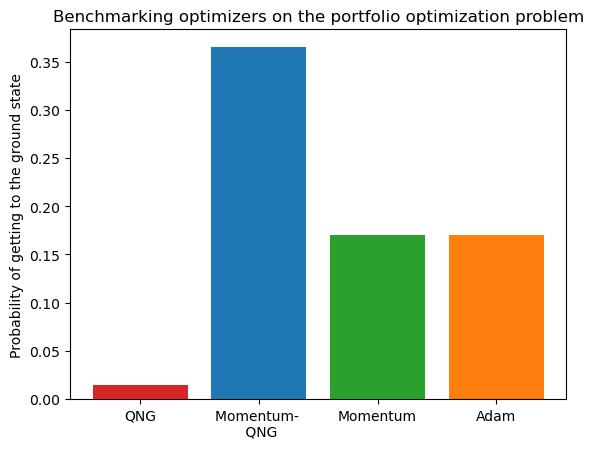

100%|██████████| 100/100 [1:38:11<00:00, 58.91s/it]

Cost after shot   300: adam: -1.9083624, qng: -1.7292044, mqng: -1.9083544, sgd: -1.8887700
[0.023333333333333334, 0.36666666666666664, 0.19333333333333333, 0.18]


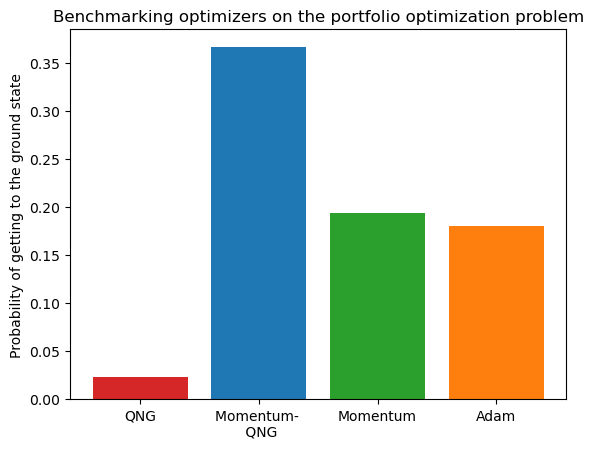

100%|██████████| 100/100 [1:12:55<00:00, 43.75s/it]

Cost after shot   400: adam: -1.9083621, qng: -1.5136532, mqng: -1.7214208, sgd: -1.9074226
[0.0375, 0.36, 0.1825, 0.1825]


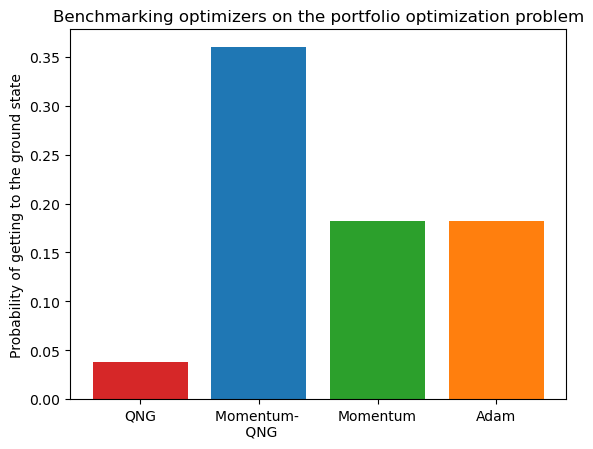

100%|██████████| 100/100 [1:11:30<00:00, 42.90s/it]

Cost after shot   500: adam: -1.7210838, qng: -1.7044324, mqng: -1.9083628, sgd: -1.7208456
[0.038, 0.378, 0.178, 0.178]


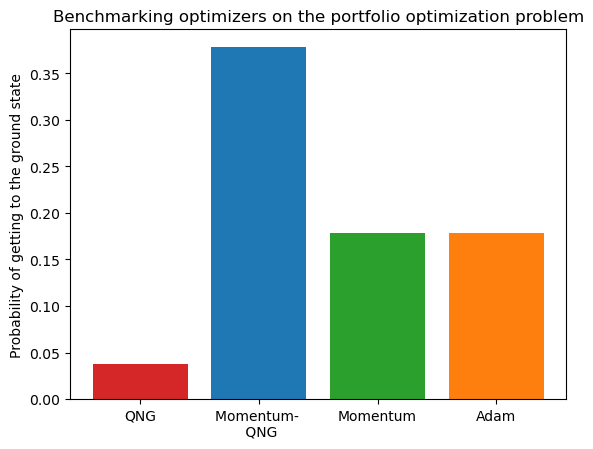

  1%|          | 1/100 [01:21<2:15:10, 81.92s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
optimizers = ['QNG', 'Momentum- \n QNG', 'Momentum', 'Adam']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']


iterations=300
qng_step = 0.02
sgd_step = 0.02
adam_step = 0.08
shots=100
best_cost = 9999.9999
qng_cost = []
mqng_cost = []
sgd_cost = []
adam_cost = []
hits = [0.0, 0.0, 0.0, 0.0]
ground_energy = -1.9083156
np.random.seed(31415)
for ibatch in range(20):
    for n in tqdm(range(shots)):
        init_params = np.random.rand((p+1)*N)
        params_qng = qng_session(init_params, qng_step, iterations)
        cost_qng = cost(params_qng)
        qng_cost.append(cost_qng)
        if abs(cost_qng - ground_energy) <= 0.01:
            hits[0] += 1

        params_mqng = momentum_qng_session(init_params, qng_step, 0.9, iterations)
        cost_mqng = cost(params_mqng)
        mqng_cost.append(cost_mqng)
        if abs(cost_mqng - ground_energy) <= 0.01:
              hits[1] += 1

        params_sgd = momentum_session(init_params, sgd_step, 0.9, iterations)
        cost_sgd = cost(params_sgd)
        sgd_cost.append(cost_sgd)
        if abs(cost_sgd - ground_energy) <= 0.01:
              hits[2] += 1

        params_adam = adam_session(init_params, adam_step, iterations)
        cost_adam = cost(params_adam)
        adam_cost.append(cost_adam)
        if abs(cost_adam - ground_energy) <= 0.01:
            hits[3] += 1
    probs = [0.0,0.0,0.0,0.0]
    for ii in range(4):
        probs[ii] = hits[ii]/((ibatch+1)*shots)

    print("Cost after shot {:5d}: adam: {: .7f}, qng: {: .7f}, mqng: {: .7f}, sgd: {: .7f}"
          .format((ibatch+1)*shots, cost_adam, cost_qng, cost_mqng, cost_sgd))
    print(probs)

    fig, ax = plt.subplots()
    ax.set_ylabel('Probability of getting to the ground state')
    ax.set_title('Benchmarking optimizers on the portfolio optimization problem')

    ax.bar(optimizers, probs, color=bar_colors)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

optimizers = ['QNG', 'Momentum- \n QNG', 'Momentum', 'Adam']
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

ax.bar(optimizers, hits, color=bar_colors)

ax.set_ylabel('Count of getting to the ground state')
ax.set_title('Benchmarking optimizers on the portfolio optimization problem')

plt.show()